In [ ]:
import pathlib
import numpy as np

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [ ]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/blood-cells

 90% 97.0M/108M [00:03<00:00, 30.8MB/s]
100% 108M/108M [00:03<00:00, 35.2MB/s] 


In [ ]:
%mkdir -p dataset/

In [ ]:
!unzip -q blood-cells.zip -d dataset/

In [ ]:
data_dir = pathlib.Path("dataset/dataset2-master/dataset2-master/images/TRAIN")

In [ ]:
valid_data_dir = pathlib.Path("dataset/dataset2-master/dataset2-master/images/TEST")

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
image_count

9957

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['LYMPHOCYTE', 'EOSINOPHIL', 'MONOCYTE', 'NEUTROPHIL'], dtype='<U10')

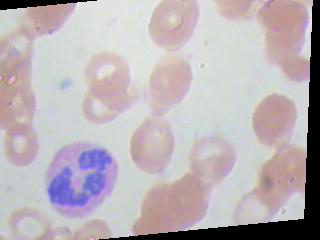

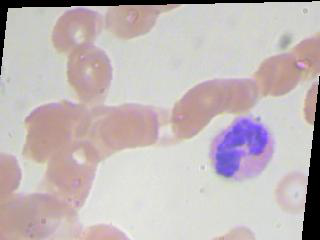

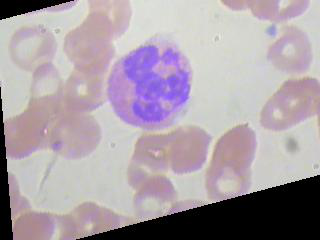

In [ ]:
EOSINOPHILS = list(data_dir.glob('EOSINOPHIL/*'))

for image_path in EOSINOPHILS[:3]:
    display.display(Image.open(str(image_path)))

In [ ]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [ ]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 9957 images belonging to 4 classes.


In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

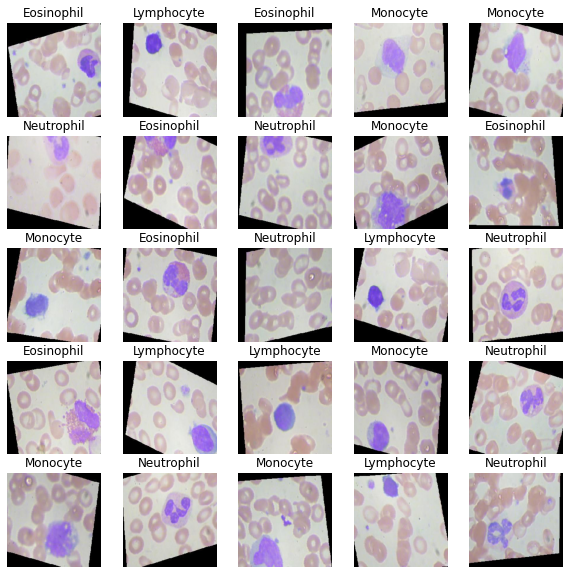

In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

#USING tf.data

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

NameError: ignored

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

NameError: ignored

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

In [ ]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [ ]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
labeled_ds

#Train and Test

In [ ]:
#setup generator
train_generator = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     color_mode = 'rgb',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                      class_mode="sparse")

test_generator = image_generator.flow_from_directory(directory=str(valid_data_dir),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode="sparse")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
test_generator.class_indices

{'EOSINOPHIL': 1, 'LYMPHOCYTE': 0, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [ ]:
n_classes=4
base_model = keras.applications.InceptionResNetV2(weights="imagenet", include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes,activation="softmax")(avg)
model = keras.Model(inputs = base_model.input, outputs=output)

219062272/219055592 [==============================] - 4s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-06, amsgrad=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy" , optimizer=optimizer , metrics=["accuracy"])

In [ ]:
history = model.fit_generator(train_generator, epochs=60,
                              validation_data = test_generator,
                              callbacks=[early_stop])

Epoch 1/60
312/312 [==============================] - 161s 515ms/step - loss: 1.3321 - accuracy: 0.3612 - val_loss: 1.3084 - val_accuracy: 0.4093
Epoch 2/60
312/312 [==============================] - 156s 499ms/step - loss: 1.2293 - accuracy: 0.4660 - val_loss: 1.2405 - val_accuracy: 0.4781
Epoch 3/60
312/312 [==============================] - 156s 498ms/step - loss: 1.1654 - accuracy: 0.5139 - val_loss: 1.1965 - val_accuracy: 0.5070
Epoch 4/60
312/312 [==============================] - 156s 499ms/step - loss: 1.1158 - accuracy: 0.5497 - val_loss: 1.1638 - val_accuracy: 0.5255
Epoch 5/60
312/312 [==============================] - 156s 499ms/step - loss: 1.0744 - accuracy: 0.5764 - val_loss: 1.1377 - val_accuracy: 0.5219
Epoch 6/60
312/312 [==============================] - 155s 498ms/step - loss: 1.0398 - accuracy: 0.5947 - val_loss: 1.1155 - val_accuracy: 0.5368
Epoch 7/60
312/312 [==============================] - 155s 497ms/step - loss: 1.0091 - accuracy: 0.6161 - val_loss: 1.1024 -

In [ ]:
for layer in base_model.layers:
  layer.trainable = True

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-06, amsgrad=True)
model.compile(loss="sparse_categorical_crossentropy" , optimizer=optimizer , metrics=["accuracy"])
history = model.fit_generator(train_generator, epochs=5,
                              validation_data = test_generator,
                              callbacks=[early_stop])

Epoch 1/5
312/312 [==============================] - 463s 1s/step - loss: 0.1441 - accuracy: 0.9434 - val_loss: 1.1498 - val_accuracy: 0.8118
Epoch 2/5
312/312 [==============================] - 459s 1s/step - loss: 0.0125 - accuracy: 0.9950 - val_loss: 1.2085 - val_accuracy: 0.8295
Epoch 3/5
312/312 [==============================] - 458s 1s/step - loss: 0.0168 - accuracy: 0.9943 - val_loss: 1.1211 - val_accuracy: 0.8231
Epoch 4/5
312/312 [==============================] - 458s 1s/step - loss: 0.0285 - accuracy: 0.9919 - val_loss: 1.1216 - val_accuracy: 0.8343
Epoch 5/5
312/312 [==============================] - 459s 1s/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 1.2141 - val_accuracy: 0.8275


In [ ]:
history = model.fit_generator(train_generator, epochs=5,
                              validation_data = test_generator,
                              callbacks=[early_stop])

Epoch 1/5
312/312 [==============================] - 458s 1s/step - loss: 8.9734e-04 - accuracy: 0.9998 - val_loss: 1.5520 - val_accuracy: 0.8191
Epoch 2/5
312/312 [==============================] - 458s 1s/step - loss: 2.2852e-04 - accuracy: 1.0000 - val_loss: 1.2145 - val_accuracy: 0.8496
Epoch 3/5
312/312 [==============================] - 458s 1s/step - loss: 3.3458e-04 - accuracy: 1.0000 - val_loss: 1.2639 - val_accuracy: 0.8307
Epoch 4/5
 49/312 [===>..........................] - ETA: 5:55 - loss: 6.5552e-05 - accuracy: 1.0000

In [ ]:
history.history

{'accuracy': [0.937933087348938,
  0.9952797293663025,
  0.9972883462905884,
  0.9997991323471069,
  0.9994978308677673],
 'loss': [0.16275060176849365,
  0.015099930576980114,
  0.008003105409443378,
  0.0014159526908770204,
  0.0011921761324629188],
 'val_accuracy': [0.8850020170211792,
  0.8661037683486938,
  0.8580619096755981,
  0.8552472591400146,
  0.8451949954032898],
 'val_loss': [0.4974539577960968,
  0.9333537220954895,
  1.4069263935089111,
  1.5520795583724976,
  1.6358914375305176]}

In [ ]:
import matplotlib.pyplot as plt


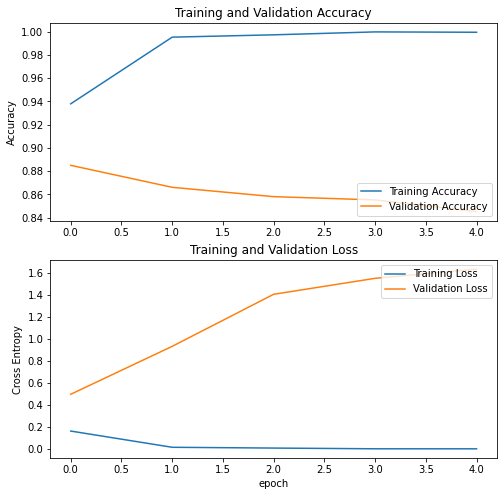

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('xcep-incep-adam')

In [ ]:
!zip -r /content/xcep_adam.zip /content/xcep-incep-adam